# Calculate and plot composites of precipitation rate anomalies in 2008

## 1. Load modules

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

In [2]:
years = np.arange(1980, 2015)
nyr = len(years)

## 2. Read model data

In [3]:
idir = '/projects/COLA/CLIM751/data/daily/'
fname = idir + 'prate/prate_daily_200801.nc' #float prate(ens,time,lat,lon); mm/day

In [4]:
ds = xr.open_dataset(fname)

In [5]:
lat = ds['lat'].sel(lat=slice(-30,30))
lon = ds['lon']
nlat = len(lat)
nlon = len(lon)

time = ds['time']
ntime = len(time)

In [6]:
prate_array = np.empty((nyr,ntime,nlat,nlon),dtype=np.float32)

In [7]:
#n = 0
for n, year in enumerate(years):
    prate_path = idir+'prate/'+f'prate_daily_{year}01.nc'
    ds_prate = xr.open_dataset(prate_path)
    prate_array[n,:,:,:] = ds_prate['prate'].sel(ens=1, lat=slice(-30, 30))
    #n += 1

In [8]:
prate_array = xr.DataArray(prate_array,dims=['years','time','lat','lon'],
                       coords={'years': years,
                              'time': time,
                              'lat': lat,
                              'lon': lon}, name = 'prate')

## 3. Calculate the precipitation rate anomaly

In [9]:
prate_clim = prate_array.mean('years')

In [10]:
prate_ano = prate_array - prate_clim

In [11]:
print(np.shape(prate_ano))

(35, 91, 60, 360)


In [12]:
ano2008 = prate_ano.sel(years=2008)

In [13]:
ano_w = np.empty((13,nlat,nlon),dtype=np.float32)

In [14]:
nn = 0
s_id = 1
interval = 8
while s_id < ntime:
    e_id = min(s_id + interval - 1, ntime - 1)
    data_slice = ano2008[s_id:e_id, :, :]
    mean_value = data_slice.mean(dim="time")
    ano_w[nn,:,:]= mean_value
    s_id += interval-1
    nn += 1

In [15]:
ano_w = xr.DataArray(ano_w,dims=['weeks','lat','lon'],
                       coords={'weeks': np.arange(1,14),
                              'lat': lat,
                              'lon': lon}, name = 'prate')

## 4. Plot the composites of precipitation rate anomalies

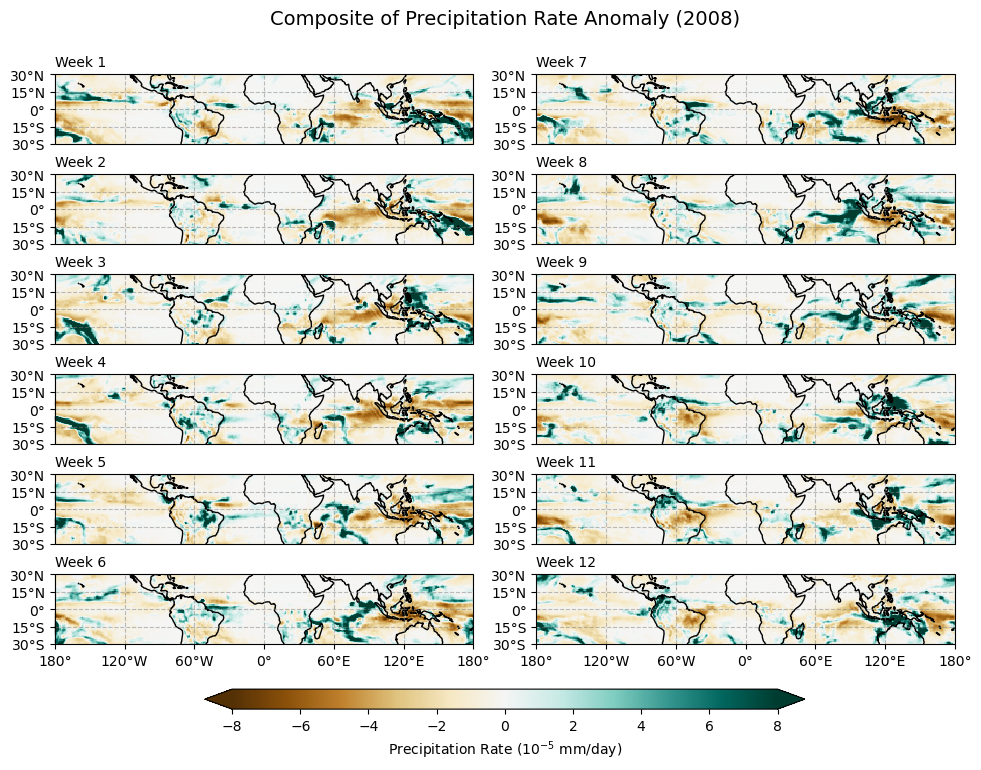

In [24]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10, 10), 
                         subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.T.ravel()

for i, ax in enumerate(axes.flat):
    im = ax.pcolormesh(lon, lat, ano_w[i]*10000,
                       vmin=-8, vmax=8,
                       cmap="BrBG", transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f"Week {i+1}",fontsize=10,loc='left')

    if (i == 5)|(i == len(ano_w)-2):
        ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)

    ax.set_yticks(np.arange(-30,31,15), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(labelsize=10)
    
    
    gl = ax.gridlines(ylocs=np.arange(-30,31,15),draw_labels=False, 
                      linestyle='--',linewidth=0.8, color='gray', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False

fig.subplots_adjust(bottom=0.2, top=0.9, left=0.05, right=0.95,
                    wspace=0.15, hspace=-0.5)

cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(im, cax=cbar_ax,orientation='horizontal',label='˚C', extend='both')
cbar.ax.tick_params(labelsize=10)
cbar.set_label("Precipitation Rate (10$^{-5}$ mm/day)", fontsize=10)

plt.suptitle('Composite of Precipitation Rate Anomaly (2008)',y=0.9, fontsize=14)
plt.savefig('plot_map_multi_prate_wkly_2008.png',dpi=300,bbox_inches="tight", pad_inches=0.1)
plt.show()